In [1]:
import warnings
warnings.filterwarnings("ignore")

首先我们将以一个简单的线性回归模型为例，讨论两种不同的训练方法来得到模型的最优解：

直接使用封闭方程进行求根运算，得到模型在当前训练集上的最优参数（即在训练集上使损失函数达到最小值的模型参数）

使用迭代优化方法：**梯度下降（GD**），在训练集上，它可以逐渐调整模型参数以获得最小的损失函数，最终，参数会收敛到和第一种方法相同的的值。同时，我们也会介绍一些梯度下降的变体形式：**批量梯度下降（Batch GD）、小批量梯度下降（Mini-batch GD）、随机梯度下降（Stochastic GD）**，在第二部分的神经网络部分，我们会多次使用它们。

接下来，我们将研究一个更复杂的模型：**多项式回归，它可以拟合非线性数据集**，由于它比线性模型拥有更多的参数，更容易出现模型的过拟合。因此，我们将介绍如何**通过学习曲线去判断模型是否出现了过拟合**，并介绍几种**正则化方法以减少模型出现过拟合的风险**。

最后，我们将介绍两个常用于分类的模型：Logistic回归和Softmax回归。

## 线性回归

life_satisfaction = θ0 + θ1 x<br>

线性回归预测模型（向量形式）
y = hθ(x) = θT• X

MSE = np.mean(np.square(y - y_hat))<br>
RMSE = np.sqrt(np.mean(np.square(y - y_hat)))<br>
MAE = np.mean(np.abs(y-y_hat))<br>
MAPE = np.mean(np.abs((y - y_hat) / y)) * 100<br>

## 正态方程
为了找到最小化损失函数的θ值，可以采用公式解，换句话说，就是可以通过解正态方程直接得到最后的结果。

In [2]:
import numpy as np 
import matplotlib.pyplot as plt
X = 2 * np.random.rand(100, 1)
y = 4 + 3 * X + np.random.randn(100, 1)
plt.scatter(X,y)

现在让我们使用正态方程来计算θ hat，我们使用 Numpy 的线性代数模块（np.linalg）中的inv()函数来计算矩阵的逆，以及dot()方法来计算矩阵的乘法

In [3]:
X_b = np.c_[np.ones((100, 1)), X] 
theta_best = np.linalg.inv(X_b.T.dot(X_b)).dot(X_b.T).dot(y)

用来生成数据的函数是y = 4 + 3x0 + 高斯噪声。让我们看一下最后的计算结果。

In [4]:
theta_best

array([[4.22679203],
       [2.78971146]])

我们希望最后得到的参数为θ0 = 4，θ1 = 3而不是 θ0 = 3.865，θ1 = 3.139。这已经足够了，由于存在噪声，参数不可能达到到原始函数的值。

In [5]:
X_new = np.array([[0],[2]])
X_new_b = np.c_[np.ones((2, 1)), X_new]
y_predict = X_new_b.dot(theta_best)
y_predict

array([[4.22679203],
       [9.80621495]])

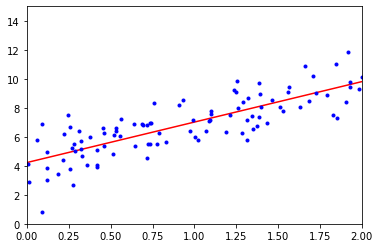

In [6]:
plt.plot(X_new,y_predict,"r-")
plt.plot(X,y,"b.")
plt.axis([0,2,0,15])
plt.show()

In [7]:
X_new_b

array([[1., 0.],
       [1., 2.]])

In [8]:
from sklearn.linear_model import LinearRegression
lin_reg = LinearRegression()
lin_reg.fit(X,y)
print(lin_reg.intercept_, lin_reg.coef_)
lin_reg.predict(X_new)

[4.22679203] [[2.78971146]]


array([[4.22679203],
       [9.80621495]])

## 计算复杂度
正态方程需要计算矩阵XT的逆。X是一个n x n的矩阵（n是特征的个数）。这样一个矩阵求逆的运算复杂度大约在**O(n^2.4)到O(n^3)**之间，具体值取决于计算方式。换句话说，如果你将你的特征个数翻倍的话，其计算时间大概会变为原来的 2^2.4 = 5.3 到 2^3 = 8倍。
警告
当特征的个数较大的时候（例如：特征数量为 100000），正态方程求解将会非常慢。

有利的一面是，这个方程在训练集上对于每一个实例来说是线性的，其复杂度为O(m)，因此只要有能放得下它的内存空间，它就可以对大规模数据进行训练。同时，一旦你得到了线性回归模型（通过解正态方程或者其他的算法），进行预测是非常快的。因为模型中计算复杂度对于要进行预测的实例数量和特征个数都是线性的。 换句话说，当实例个数变为原来的两倍多的时候（或特征个数变为原来的两倍多），预测时间也仅仅是原来的两倍多。

接下来，我们将介绍另一种方法去训练模型。这种方法适合在特征个数非常多，训练实例非常多，内存无法满足要求的时候使用。

## 梯度下降
梯度下降是一种非常通用的优化算法，它能够很好地解决一系列问题。梯度下降的整体思路是通过的迭代来逐渐调整参数使得损失函数达到最小值。

假设浓雾下，你迷失在了大山中，你只能感受到自己脚下的坡度。为了最快到达山底，一个最好的方法就是沿着坡度最陡的地方下山。这其实就是梯度下降所做的：它计算误差函数关于参数向量θ的局部梯度，同时它沿着梯度下降的方向进行下一次迭代。当梯度值为零的时候，就达到了误差函数最小值 。

具体来说，开始时，需要选定一个随机的θ（这个值称为随机初始值），然后逐渐去改进它，每一次变化一小步，每一步都尝试降低损失函数（例如：均方差损失函数），直到算法收敛到一个最小值（如图：4-3）。


在梯度下降中一个重要的参数是步长，超参数学习率的值决定了步长的大小。如果学习率太小，必须经过多次迭代，算法才能收敛，这是非常耗时的.

另一方面，如果学习率太大，你将跳过最低点，到达山谷的另一面，可能下一次的值比上一次还要大。这可能使的算法是发散的，函数值变得越来越大，永远不可能找到一个好的答案

最后，并不是所有的损失函数看起来都像一个规则的碗。它们可能是洞，山脊，高原和各种不规则的地形，使它们收敛到最小值非常的困难。 梯度下降的两个主要挑战：如果随机初始值选在了图像的左侧，则它将收敛到局部最小值，这个值要比全局最小值要大。 如果它从右侧开始，那么跨越高原将需要很长时间，如果你早早地结束训练，你将永远到不了全局最小值。

幸运的是**线性回归模型的均方差损失函数是一个凸函数**，这意味着如果你选择曲线上的任意两点，这两个点的连线不会与曲线发生交叉（译者注：该线段不会与曲线有第三个交点）。**这意味着这个损失函数没有局部最小值，仅仅只有一个全局最小值**。同时它也是一个斜率不能突变的连续函数。这两个因素导致了一个好的结果：梯度下降可以无限接近全局最小值。（只要你训练时间足够长，同时学习率不是太大 ）。

**警告**<br>
当我们使用梯度下降的时候，应该确保所有的特征有着相近的尺度范围（例如：使用 Scikit Learn 的 StandardScaler类），否则它将需要很长的时间才能够收敛。

## 批量梯度下降
使用梯度下降的过程中，你需要计算对于损失函数对每一个模型参数θj的梯度。换句话说，你需要计算当θj变化一点点时，损失函数改变了多少。这称为偏导数，它就像当你面对东方的时候问："我脚下的坡度是多少？"。然后面向北方的时候问同样的问题（如果你能想象一个超过三维的宇宙，可以对所有的方向都这样做）
处。

In [9]:
eta = 0.1 # 学习率
n_iterations = 1000
m = 100

theta = np.random.randn(2,1) # 随机初始值

for iteration in range(n_iterations):
    gradients = 2/m * X_b.T.dot(X_b.dot(theta) - y)
    theta = theta - eta * gradients
theta

array([[4.22679203],
       [2.78971146]])

**收敛速率**<br>
当损失函数是凸函数，同时它的斜率不能突变（就像均方差损失函数那样），那么它的批量梯度下降算法固定学习率之后，它的收敛速率是O(1/iterations)。换句话说，如果你将容差 ϵ缩小 10 倍后（这样可以得到一个更精确的结果），这个算法的迭代次数大约会变成原来的 10 倍。


## 随机梯度下降
批量梯度下降的主要问题是计算每一步的梯度时都需要使用整个训练集，这导致在规模较大的数据集上，会变得非常的慢。与其完全相反的随机梯度下降，在每一步的梯度计算上只随机选取训练集中的一个样本。很明显，由于每一次的操作都使用了非常少的数据，这样使得算法变得非常快。由于每一次迭代，只需要在内存中有一个实例，这使**随机梯度算法**可以在大规模训练集上使用。

另一方面，由于它的随机性，与批量梯度下降相比，其呈现出更多的不规律性：它到达最小值不是平缓的下降，**损失函数会忽高忽低，只是在大体上呈下降趋势**。随着时间的推移，它会非常的靠近最小值，但是它不会停止在一个值上，它会一直在这个值附近摆动（如图 4-9）。因此，当算法停止的时候，最后的参数还不错，但不是最优值。


随机梯度下降算法能够跳过局部最小值。因此，随机梯度下降在寻找全局最小值上比批量梯度下降表现要好。

虽然随机性可以很好的跳过局部最优值，但同时它却不能达到最小值。解决这个难题的一个办法是逐渐降低学习率。 开始时，走的每一步较大（这有助于快速前进同时跳过局部最小值），然后变得越来越小，从而使算法到达全局最小值。 这个过程被称为模拟退火，因为它类似于熔融金属慢慢冷却的冶金学退火过程。 决定每次迭代的学习率的函数称为learning schedule。 如果学习速度降低得过快，你可能会陷入局部最小值，甚至在到达最小值的半路就停止了。 如果学习速度降低得太慢，你可能在最小值的附近长时间摆动，同时如果过早停止训练，最终只会出现次优解。

下面的代码使用一个简单的learning schedule来实现随机梯度下降：

In [10]:
n_epochs = 50 
t0, t1 = 5, 50  #learning_schedule的超参数

def learning_schedule(t):
    return t0 / (t + t1)

theta = np.random.randn(2,1)

for epoch in range(n_epochs):
    for i in range(m):
        random_index = np.random.randint(m)
        xi = X_b[random_index:random_index+1]
        yi = y[random_index:random_index+1]
        gradients = 2 * xi.T.dot(xi.dot(theta)-yi)
        eta = learning_schedule(epoch * m + i)
        theta = theta - eta * gradients

按习惯来讲，我们进行m轮的迭代，每一轮迭代被称为一代。在整个训练集上，随机梯度下降迭代了 1000 次时，一般在第 50 次的时候就可以达到一个比较好的结果。

In [11]:
theta

array([[4.2253096 ],
       [2.78897361]])

由于每个实例的选择是随机的，有的实例可能在每一代中都被选到，这样其他的实例也可能一直不被选到。如果你想保证每一代迭代过程，算法可以遍历所有实例，一种方法是将训练集打乱重排，然后选择一个实例，之后再继续打乱重排，以此类推一直进行下去。但是这样收敛速度会非常的慢。

通过使用 Scikit-Learn 完成线性回归的随机梯度下降，你需要使用SGDRegressor类，这个类默认优化的是均方差损失函数。下面的代码迭代了50次，初始学习率为0.1（eta0=0.1），使用默认的learning schedule（与前面的不一样），同时也没有添加任何正则项（penalty = None）：


In [12]:
from sklearn.linear_model import SGDRegressor
sgd_reg = SGDRegressor(max_iter=50, penalty=None, eta0=0.1,validation_fraction=0.2,early_stopping=True)
sgd_reg.fit(X,y.ravel())
sgd_reg.intercept_, sgd_reg.coef_

(array([4.09760698]), array([2.85599374]))

## 小批量梯度下降
最后一个梯度下降算法，我们将介绍小批量梯度下降算法。一旦你理解了批量梯度下降和随机梯度下降，再去理解小批量梯度下降是非常简单的。在迭代的每一步，批量梯度使用整个训练集，随机梯度时候用仅仅一个实例，在小批量梯度下降中，它则使用一个随机的小型实例集。**它比随机梯度的主要优点在于你可以通过矩阵运算的硬件优化得到一个较好的训练效果，尤其当你使用 GPU 进行运算的时候**。

小批量梯度下降在参数空间上的表现比随机梯度下降要好的多，尤其在有大量的小型实例集时。作为结果，小批量梯度下降会比随机梯度更靠近最小值。但是，另一方面，**它有可能陷在局部最小值中（在遇到局部最小值问题的情况下，和我们之前看到的线性回归不一样）**。 图4-11显示了训练期间三种梯度下降算法在参数空间中所采用的路径。 他们都接近最小值，但批量梯度的路径最后停在了最小值，而随机梯度和小批量梯度最后都在最小值附近摆动。 但是，不要忘记，批次梯度需要花费大量时间来完成每一步，但是，如果你使用了一个较好的learning schedule，随机梯度和小批量梯度也可以得到最小值。

## 多项式回归
如果你的数据实际上比简单的直线更复杂呢？ 令人惊讶的是，你依然可以使用线性模型来拟合非线性数据。 一个简单的方法是对每个特征进行加权后作为新的特征，然后训练一个线性模型在这个扩展的特征集。 这种方法称为多项式回归。

让我们看一个例子。 首先，我们根据一个简单的二次方程（并加上一些噪声，如图 4-12）来生成一些非线性数据：


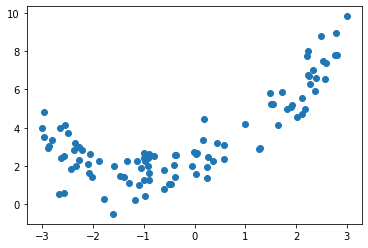

In [185]:
m = 100
X = 6 * np.random.rand(m, 1) - 3
y = 0.5 * X**2 + X + 2 + np.random.randn(m, 1)
plt.scatter(X,y)

很清楚的看出，直线不能恰当的拟合这些数据。于是，我们使用 Scikit-Learning 的PolynomialFeatures类进行训练数据集的转换，让训练集中每个特征的平方（2 次多项式）作为新特征（在这种情况下，仅存在一个特征）：

In [186]:
from sklearn.preprocessing import PolynomialFeatures
poly_features = PolynomialFeatures(degree=2,include_bias=False)
X_poly = poly_features.fit_transform(X)
X[0], X_poly[0]

(array([0.99359498]), array([0.99359498, 0.98723098]))

X_poly现在包含原始特征X并加上了这个特征的平方X2。现在你可以在这个扩展训练集上使用LinearRegression模型进行拟合，如图 4-13：

In [15]:
lin_reg = LinearRegression()
lin_reg.fit(X_poly, y)
lin_reg.intercept_, lin_reg.coef_

(array([1.83456568]), array([[0.99769554, 0.54760325]]))

Text(0.5, 1.0, 'PolynomialFeatures')

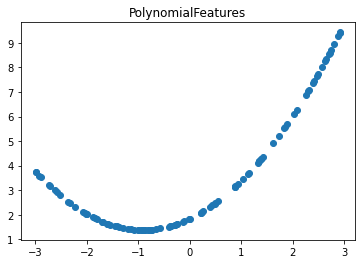

In [16]:
y_predict = lin_reg.predict(X_poly)
plt.scatter(X, y_predict)
plt.title('PolynomialFeatures')

还是不错的，模型预测函数是\hat{y}=0.56x_1^2+0.93x_1+1.78，实际的原始函数是y=0.5x_1^2+1.0x_1+2.0。
请注意，当存在多个特征时，多项式回归能够找出特征之间的关系（这是普通线性回归模型无法做到的）。 这是因为LinearRegression会自动添加当前阶数下特征的所有组合。例如，如果有两个特征a和b，使用 3 阶（degree=3）的LinearRegression时，不仅有会有a2、a3、b2、b3，还会有组合项ab、a2b、ab2。

提示<br>
PolynomialFeatures(degree=d)把一个包含n个特征的数组转换为一个包含(n+d)!/d!n!个特征的数组，n!是n的阶乘，等于1 × 2 × 3 × ⋯ × n。小心大量特征的组合爆炸

## 学习曲线
如果你使用一个高阶的多项式回归，你可能发现它的拟合程度要比普通的线性回归要好的多。例如，图 4-14 使用一个 300 阶的多项式模型去拟合之前的数据集，并同简单线性回归、2 阶的多项式回归进行比较。注意 300 阶的多项式模型如何摆动以尽可能接近训练实例。
。

当然，这种**高阶多项式回归模型在这个训练集上严重过拟合了，线性模型则欠拟合**。在这个训练集上，二次模型有着较好的泛化能力。那是因为在生成数据时使用了二次模型，但是一般我们不知道这个数据生成函数是什么，那我们该如何决定我们模型的复杂度呢？你如何区分你的模型是过拟合还是欠拟合？

在第二章，你可以使用交叉验证来估计一个模型的泛化能力。如果一个模型在训练集上表现良好，通过交叉验证指标却得出其泛化能力很差，那么你的模型就是过拟合了。如果在这两方面都表现不好，那么它就是欠拟合了。这种方法可以告诉我们，你的模型是太复杂还是太简单了。

另一种方法是观察学习曲线：画出模型在训练集上的表现，同时画出以训练集规模为自变量的训练集函数。为了得到图像，需要在训练集的不同规模子集上进行多次训练。下面的代码定义了一个函数，用来画出给定训练集后的模型学习曲线：


In [199]:
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

def plot_learning_curves(model, X, y):
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)
    train_errors, val_errors = [], []
    for m in range(1, len(X_train)):
        model.fit(X_train[:m], y_train[:m])
        y_train_predict = model.predict(X_train[:m])
        y_val_predict = model.predict(X_val)
        train_errors.append(mean_squared_error(y_train_predict, y_train[:m]))
        val_errors.append(mean_squared_error(y_val_predict, y_val))
    plt.plot(np.sqrt(train_errors), "r-+", linewidth=2, label="train")
    plt.plot(np.sqrt(val_errors), "b-", linewidth=3, label="val")
    plt.legend()
    plt.title('Traing set size', loc='center')

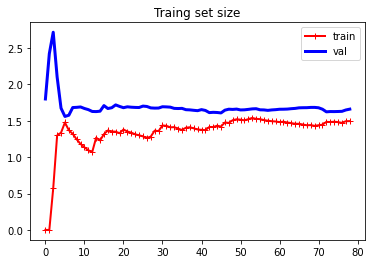

In [201]:
lin_reg = LinearRegression()
plot_learning_curves(lin_reg, X, y)

这幅图值得我们深究。首先，我们观察在训练集上的效果：当训练集只有一两个样本的时候，模型能够非常好的拟合它们，这也是为什么曲线是从零开始的原因。但是当加入了一些新的样本的时候，训练集上的拟合程度变得难以接受，出现这种情况有两个原因，一是因为数据中含有噪声，另一个是数据根本不是线性的。因此随着数据规模的增大，误差也会一直增大，直到达到高原地带并趋于稳定，在之后，继续加入新的样本，模型的平均误差不会变得更好或者更差。我们继续来看模型在验证集上的表现，当以非常少的样本去训练时，模型不能恰当的泛化，也就是为什么验证误差一开始是非常大的。当训练样本变多的到时候，模型学习的东西变多，验证误差开始缓慢的下降。但是一条直线不可能很好的拟合这些数据，因此最后误差会到达在一个高原地带并趋于稳定，最后和训练集的曲线非常接近.

上面的曲线表现了一个典型的欠拟合模型，两条曲线都到达高原地带并趋于稳定，并且最后两条曲线非常接近，同时误差值非常大。

提示

如果你的模型在训练集上是欠拟合的，添加更多的样本是没用的。你需要使用一个更复杂的模型或者找到更好的特征。

现在让我们看一个在相同数据上10阶多项式模型拟合的学习曲线（图 4-16）：

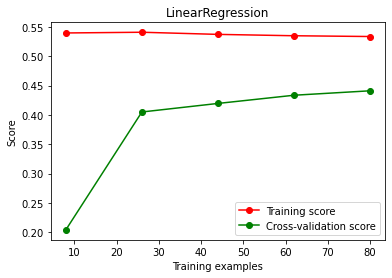

In [232]:
from sklearn.model_selection import learning_curve
ylim=None; train_sizes=np.linspace(.1, 1.0, 5)
cv = ShuffleSplit(n_splits=100, test_size=0.2, random_state=0)
n_jobs=4
fig, axes = plt.subplots()


axes.set_title('LinearRegression')
if ylim is not None:
    axes.set_ylim(*ylim)
axes.set_xlabel("Training examples")
axes.set_ylabel("Score")

train_sizes, train_scores, test_scores, fit_times, _ = \
    learning_curve(lin_reg, X, y, cv=cv, n_jobs=n_jobs,
                   train_sizes=train_sizes,
                   return_times=True)
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)
fit_times_mean = np.mean(fit_times, axis=1)
fit_times_std = np.std(fit_times, axis=1)

# Plot learning curve

axes.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
axes.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")
axes.legend(loc="best")

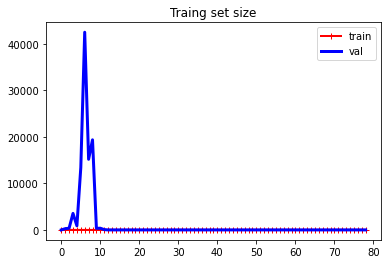

In [244]:
from sklearn.pipeline import Pipeline

polynomial_regression = Pipeline((
    ("poly_features", PolynomialFeatures(degree=10, include_bias=False)),
    ("sgd_reg", LinearRegression()),
))

plot_learning_curves(polynomial_regression, X, y)

这幅图像和之前的有一点点像，但是其有两个非常重要的不同点：

在训练集上，误差要比线性回归模型低的多。
图中的两条曲线之间有间隔，这意味模型在训练
集上的表现要比验证集上好的多，这也是模型过拟合的显著特点。当然，如果你使用了更大的训练数据，这两条曲线最后会非常的接近。

提示
改善模型过拟合的一种方法是**提供更多的训练数据，直到训练误差和验证误差相等**。

偏差和方差的权衡

在统计和机器学习领域有个重要的理论：一个模型的泛化误差由三个不同误差的和决定：

**偏差**：泛化误差的这部分误差是由于错误的假设决定的。例如实际是一个二次模型，你却假设了一个线性模型。一个高偏差的模型最容易出现欠拟合。<br>
**方差**：这部分误差是由于模型对训练数据的微小变化较为敏感，一个多自由度的模型更容易有高的方差（例如一个高阶多项式模型），因此会导致模型过拟合。<br>
**不可约误差**：这部分误差是由于数据本身的噪声决定的。降低这部分误差的唯一方法就是进行数据清洗（例如：修复数据源，修复坏的传感器，识别和剔除异常值）。

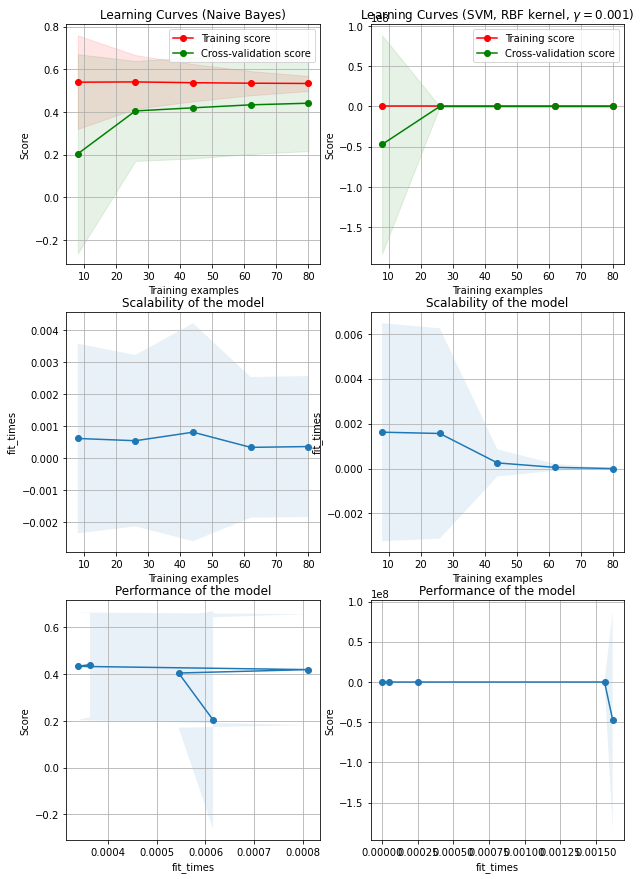

In [235]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.datasets import load_digits
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit


def plot_learning_curve(estimator, title, X, y, axes=None, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):

    if axes is None:
        _, axes = plt.subplots(1, 3, figsize=(20, 5))

    axes[0].set_title(title)
    if ylim is not None:
        axes[0].set_ylim(*ylim)
    axes[0].set_xlabel("Training examples")
    axes[0].set_ylabel("Score")

    train_sizes, train_scores, test_scores, fit_times, _ = \
        learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs,
                       train_sizes=train_sizes,
                       return_times=True)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)

    # Plot learning curve
    axes[0].grid()
    axes[0].fill_between(train_sizes, train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std, alpha=0.1,
                         color="r")
    axes[0].fill_between(train_sizes, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1,
                         color="g")
    axes[0].plot(train_sizes, train_scores_mean, 'o-', color="r",
                 label="Training score")
    axes[0].plot(train_sizes, test_scores_mean, 'o-', color="g",
                 label="Cross-validation score")
    axes[0].legend(loc="best")

    # Plot n_samples vs fit_times
    axes[1].grid()
    axes[1].plot(train_sizes, fit_times_mean, 'o-')
    axes[1].fill_between(train_sizes, fit_times_mean - fit_times_std,
                         fit_times_mean + fit_times_std, alpha=0.1)
    axes[1].set_xlabel("Training examples")
    axes[1].set_ylabel("fit_times")
    axes[1].set_title("Scalability of the model")

    # Plot fit_time vs score
    axes[2].grid()
    axes[2].plot(fit_times_mean, test_scores_mean, 'o-')
    axes[2].fill_between(fit_times_mean, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1)
    axes[2].set_xlabel("fit_times")
    axes[2].set_ylabel("Score")
    axes[2].set_title("Performance of the model")

    return plt


fig, axes = plt.subplots(3, 2, figsize=(10, 15))

# X, y = load_digits(return_X_y=True)

title = "Learning Curves (Naive Bayes)"
# Cross validation with 100 iterations to get smoother mean test and train
# score curves, each time with 20% data randomly selected as a validation set.
cv = ShuffleSplit(n_splits=100, test_size=0.2, random_state=0)

estimator = LinearRegression()
plot_learning_curve(estimator, title, X, y, axes=axes[:, 0], 
                    cv=cv, n_jobs=4)

title = r"Learning Curves (SVM, RBF kernel, $\gamma=0.001$)"
# SVC is more expensive so we do a lower number of CV iterations:
cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=0)
estimator = polynomial_regression
plot_learning_curve(estimator, title, X, y, axes=axes[:, 1], 
                    cv=cv, n_jobs=4)

plt.show()

## 线性模型的正则化
正如我们在第一和第二章看到的那样，降低模型的过拟合的好方法是正则化这个模型（即限制它）：模型有越少的自由度，就越难以拟合数据。例如，正则化一个多项式模型，一个简单的方法就是减少多项式的阶数。

对于一个线性模型，正则化的典型实现就是约束模型中参数的权重。 接下来我们将介绍三种不同约束权重的方法：岭回归，Lasso回归和弹性网络（Elastic Net）。

正如我们在第一和第二章看到的那样，降低模型的过拟合的好方法是正则化这个模型（即限制它）：模型有越少的自由度，就越难以拟合数据。例如，正则化一个多项式模型，一个简单的方法就是减少多项式的阶数。

对于一个线性模型，正则化的典型实现就是约束模型中参数的权重。 接下来我们将介绍三种不同约束权重的方法：岭回归，Lasso回归和弹性网络（Elastic Net）。

### 岭（Ridge）回归
岭回归（也称为 Tikhonov 正则化）是线性回归的正则化版：在损失函数上直接加上一个正则项。这使得学习算法不仅能够拟合数据，而且能够使模型的参数权重尽量的小。注意到这个正则项只有在训练过程中才会被加到损失函数。当得到完成训练的模型后，我们应该使用没有正则化的测量方法去评价模型的表现。

笔记
一般情况下，训练过程使用的损失函数和测试过程使用的评价函数是不一样的。除了正则化，还有一个不同：训练时的损失函数应该在优化过程中易于求导，而在测试过程中，评价函数更应该接近最后的客观表现。一个好的例子：在分类训练中我们使用对数损失（马上我们会讨论它）作为损失函数，但是我们却使用精确率/召回率来作为它的评价函数。

超参数α决定了你想正则化这个模型的强度。如果α=0那此时的岭回归便变为了线性回归。如果α非常的大，所有的权重最后都接近于零，最后结果将是一条穿过数据平均值的水平直线。公式 4-8 是岭回归的损失函数：
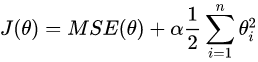


值得注意的是偏差项是没有被正则化的（累加运算的开始是i=1而不是i=0。如果定义w作为特征权重（到）的向量，那么正则项可以简写成 ，其中  表示权重向量的 范数。对于梯度下降来说仅仅在均方差梯度向量加上一项 。

提示
在使用岭回归前，对数据进行放缩（可以使用StandardScaler）是非常重要的，算法对于输入特征的数值尺度（scale）非常敏感。大多数的正则化模型都是这样的。

图 4-17 展示了在相同线性数据上使用不同α值的岭回归模型最后的表现。左图中，使用简单的岭回归模型，最后得到了线性的预测。右图中的数据首先使用 10 阶的PolynomialFearures进行扩展，然后使用StandardScaler进行缩放，最后将岭模型应用在处理过后的特征上。这就是带有岭正则项的多项式回归。注意当α增大的时候，导致预测曲线变得扁平（即少了极端值，多了一般值），这样减少了模型的方差，却增加了模型的偏差。


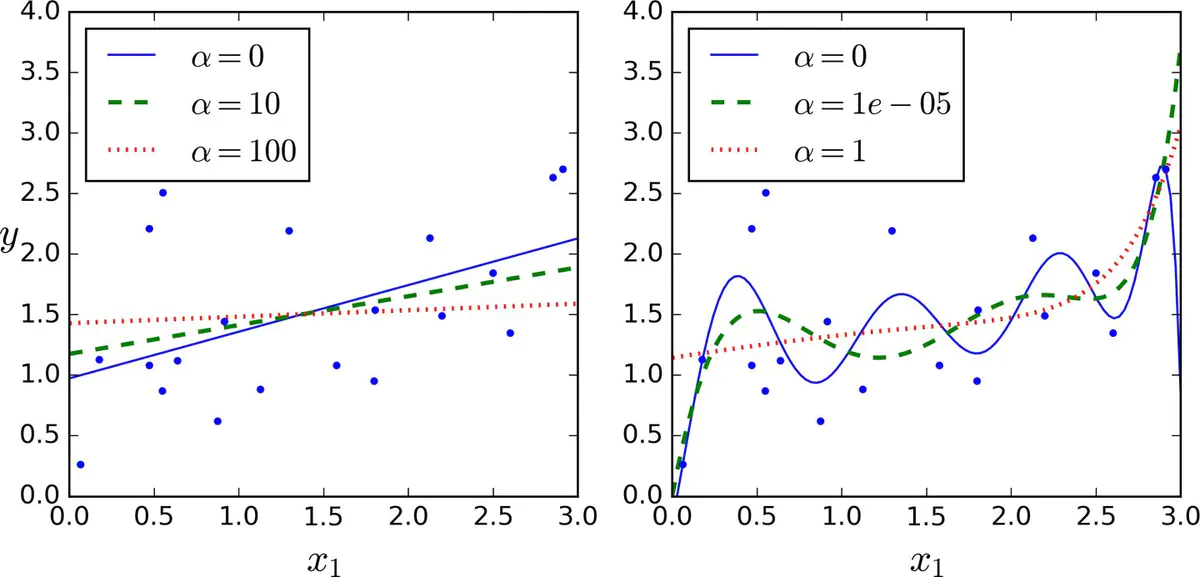

对线性回归来说，我们可以使用封闭方程去计算，也可以使用梯度下降来做岭回归。它们的缺点和优点是一样的。它们的缺点和优点是一样的。公式 4-9 表示封闭方程的解（矩阵A 是一个除了左上角有一个0的n × n 单位矩阵，这个0代表偏差项。译者注：偏差 \theta_0不是正则化的）。
下面是如何使用 Scikit-Learn 来进行封闭方程的求解


In [21]:
from sklearn.linear_model import Ridge
ridge_reg = Ridge(alpha=1, solver="cholesky")
ridge_reg.fit(X, y)
ridge_reg.predict([[1.5]])

array([[5.12153995]])

使用随机梯度法进行求解：

In [23]:
sgd_reg = SGDRegressor(penalty="l2")
sgd_reg.fit(X, y.ravel())
sgd_reg.predict([[1.5]])

array([5.13344632])

penalty参数指的是正则项的惩罚类型。指定“l2”表明你要在损失函数上添加一项：权重向量 \ell_2范数平方的一半，这就是简单的岭回归。

## Lasso 回归
Lasso 回归（也称 Least Absolute Shrinkage，或者 Selection Operator Regression）是另一种正则化版的线性回归：就像岭回归那样，它也在损失函数上添加了一个正则化项，但是它使用权重向量的范数而不是权重向量范数平方的一半。

lasso 回归的一个重要特征是它倾向于完全消除最不重要的特征的权重（即将它们设置为零）。例如，右图中的虚线所示（），曲线看起来像一条二次曲线，而且几乎是线性的，这是因为所有的高阶多项特征都被设置为零。换句话说，Lasso回归自动的进行特征选择同时输出一个稀疏模型（即，具有很少的非零权重）。

你可以从图 4-19 知道为什么会出现这种情况：在左上角图中，后背景的等高线（椭圆）表示了没有正则化的均方差损失函数，白色的小圆圈表示在当前损失函数上批量梯度下降的路径。前背景的等高线（菱形）表示惩罚，黄色的三角形表示了仅在这个惩罚下批量梯度下降的路径（）。注意路径第一次是如何到达，然后向下滚动直到它到达。在右上角图中，等高线表示的是相同损失函数再加上一个的惩罚。这幅图中，它的全局最小值在这根轴上。批量梯度下降首先到达，然后向下滚动直到达到全局最小值。 两个底部图显示了相同的情况，只是使用了惩罚。 规则化的最小值比非规范化的最小值更接近于，但权重不能完全消除。


提示<br>
在 Lasso 损失函数中，批量梯度下降的路径趋向与在低谷有一个反弹。这是因为在\theta_2=0时斜率会有一个突变。为了最后真正收敛到全局最小值，你需要逐渐的降低学习率。<br>
Lasso 损失函数在\theta_i=0(i=1,2,..,n)处无法进行微分运算，但是梯度下降如果你使用子梯度向量\mathbf{g}后它可以在任何\theta_i=0的情况下进行计算。

下面是一个使用 Scikit-Learn 的Lasso类的小例子。你也可以使用SGDRegressor(penalty="l1")来代替它。

In [24]:
from sklearn.linear_model import Lasso
lasso_reg = Lasso(alpha=0.1)
lasso_reg.fit(X, y)
lasso_reg.predict([[1.5]])

array([5.07797429])

In [25]:
sgd_reg = SGDRegressor(penalty="l1")
sgd_reg.fit(X, y.ravel())
sgd_reg.predict([[1.5]])

array([5.1175141])

## 弹性网络（ElasticNet）
弹性网络介于 Ridge 回归和 Lasso 回归之间。它的正则项是 Ridge 回归和 Lasso 回归正则项的简单混合，同时你可以控制它们的混合率，当时，弹性网络就是 Ridge 回归，当时，其就是 Lasso 回归。

那么我们该如何选择线性回归，岭回归，Lasso 回归，弹性网络呢？一般来说有一点正则项的表现更好，因此通常你应该避免使用简单的线性回归。**岭回归是一个很好的首选项**，但是如果你的**特征仅有少数是真正有用的，你应该选择 Lasso 和弹性网络**。就像我们讨论的那样，它两能够将无用特征的权重降为零。一般来说，弹性网络的表现要比 Lasso 好，因为当**特征数量比样本的数量大的时候，或者特征之间有很强的相关性时，Lasso 可能会表现的不规律**。下面是一个使用 Scikit-Learn ElasticNet（l1_ratio指的就是混合率的简单样本：

In [26]:
 from sklearn.linear_model import ElasticNet
 elastic_net = ElasticNet(alpha=0.1, l1_ratio=0.5)
 elastic_net.fit(X, y)
 elastic_net.predict([[1.5]])

array([5.07686905])

## 早期停止法（Early Stopping）
对于迭代学习算法，有一种非常特殊的正则化方法，就像梯度下降在验证错误达到最小值时立即停止训练那样。我们称为早期停止法。图 4-20 表示使用批量梯度下降来训练一个非常复杂的模型（一个高阶多项式回归模型）。随着训练的进行，算法一直学习，它在训练集上的预测误差（RMSE）自然而然的下降。然而一段时间后，验证误差停止下降，并开始上升。这意味着模型在训练集上开始出现过拟合。**一旦验证错误达到最小值，便提早停止训练**。这种简单有效的正则化方法被 Geoffrey Hinton 称为“完美的免费午餐”。

提示<br>
随机梯度和小批量梯度下降不是平滑曲线，你可能很难知道它是否达到最小值。 一种解决方案是，只有在验证误差高于最小值一段时间后（你确信该模型不会变得更好了），才停止，之后将模型参数回滚到验证误差最小值。

下面是一个早期停止法的基础应用

In [27]:
from sklearn.base import clone
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

scaler = StandardScaler()
X_train_poly_scaled, X_val_poly_scaled, y_train, y_val = train_test_split(scaler.fit_transform(X), y, test_size=0.2)

sgd_reg = SGDRegressor(max_iter=1, warm_start=True, penalty=None,learning_rate="constant", eta0=0.0005)

minimum_val_error = float("inf")
best_epoch = None
best_model = None
for epoch in range(1000):
    sgd_reg.fit(X_train_poly_scaled, y_train)
    y_val_predict = sgd_reg.predict(X_val_poly_scaled)
    val_error = mean_squared_error(y_val_predict, y_val)
    if val_error < minimum_val_error:
        minimum_val_error = val_error
        best_epoch = epoch
        best_model = clone(sgd_reg)
print('````')

````


## 逻辑回归
正如我们在第1章中讨论的那样，一些回归算法也可以用于分类（反之亦然）。 Logistic 回归（也称为 Logit 回归）通常用于估计一个实例属于某个特定类别的概率（例如，这电子邮件是垃圾邮件的概率是多少？）。 如果估计的概率大于 50%，那么模型预测这个实例属于当前类（称为正类，标记为“1”），反之预测它不属于当前类（即它属于负类 ，标记为“0”）。 这样便成为了一个二元分类器。

概率估计
那么它是怎样工作的？ 就像线性回归模型一样，Logistic 回归模型计算输入特征的加权和（加上偏差项），但它不像线性回归模型那样直接输出结果，而是把结果输入logistic()函数进行二次加工后进行输出（详见公式 4-13）。


In [28]:
import math
import latexify

@latexify.with_latex
def σ(t):
    return  1/(1 + math.exp(-t))
σ

<latexify.core.with_latex.<locals>._LatexifiedFunction at 0x2836bd3a240>

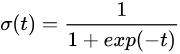

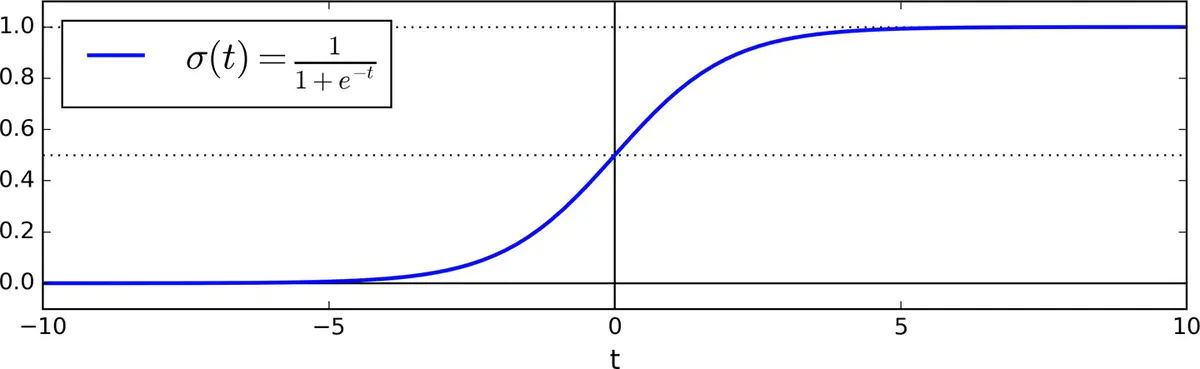

一旦 Logistic 回归模型估计得到了\mathbf{x}属于正类的概率\hat{p}=h_\theta(\mathbf{x})，那它很容易得到预测结果\hat{y}（见公式 4-15）。

公式 4-15：逻辑回归预测模型

$$\hat{y}= \begin{cases} 0, &\hat{p}<0.5 \\ 1,&\hat{p}\geq0.5 \\ \end{cases}$$

注意当t<0时\sigma(t)<0.5，当t\geq0时\sigma(t)\geq0.5，因此当\theta^T \cdot \mathbf{x}是正数的话，逻辑回归模型输出 1，如果它是负数的话，则输出 0。

## 训练和损失函数
好，现在你知道了 Logistic 回归模型如何估计概率并进行预测。 但是它是如何训练的？ 训练的目的是设置参数向量，使得正例（）概率增大，负例（）的概率减小，其通过在单个训练实例的损失函数来实现（公式 4-16）。

公式 4-16：单个样本的损失函数

$$c(\theta)= \begin{cases} -log(\hat{p}), &y=1 \\ -log(1-\hat{p}),&y=0 \\ \end{cases}$$

这个损失函数是合理的，因为当接近0时，变得非常大，所以如果模型估计一个正例概率接近于 0，那么损失函数将会很大，同时如果模型估计一个负例的概率接近 1，那么损失函数同样会很大。 另一方面，当接近于 1 时，接近 0，所以如果模型估计一个正例概率接近于 0，那么损失函数接近于0，同时如果模型估计一个负例的概率接近0，那么损失函数同样会接近于0， 这正是我们想的。

整个训练集的损失函数只是所有训练实例的平均值。可以用一个表达式（你可以很容易证明）来统一表示，称为对数损失，如公式 4-17 所示。
公式 4-17：逻辑回归的损失函数（对数损失）

$$J(\theta)=-\frac{1}{m}\sum\limits_{i=1}^m\left[y^{(i)}log\left(\hat{p}^{(i)}\right)+\left(1-y^{(i)}\right)log\left(1-\hat{p}^{(i)}\right)\right]$$

但是这个损失函数对于求解最小化损失函数的是没有公式解的（没有等价的正态方程）。 但好消息是，这个损失函数是凸的，所以梯度下降（或任何其他优化算法）一定能够找到全局最小值（如果学习速率不是太大，并且你等待足够长的时间）。公式 4-18 给出了损失函数关于第个模型参数的偏导数。

公式 4-18：逻辑回归损失函数的偏导数

$$\frac{\partial}{\partial \theta_j}J(\theta_j)=\frac{1}{m} \sum\limits_{i=1}^m{\left(\sigma\left(\theta^T \cdot \mathbf{x}^{(i)}\right)-y^{(i)}\right)}{x_j}^{(i)}$$
这个公式看起来非常像公式 4-5：首先计算每个样本的预测误差，然后误差项乘以第项特征值，最后求出所有训练样本的平均值。 一旦你有了包含所有的偏导数的梯度向量，你便可以在梯度向量上使用批量梯度下降算法。 也就是说：你已经知道如何训练 Logistic 回归模型。 对于随机梯度下降，你当然只需要每一次使用一个实例，对于小批量梯度下降，你将每一次使用一个小型实例集。

## 决策边界
我们使用鸢尾花数据集来分析 Logistic 回归。 这是一个著名的数据集，其中包含 150 朵三种不同的鸢尾花的萼片和花瓣的长度和宽度。这三种鸢尾花为：Setosa，Versicolor，Virginica<br>
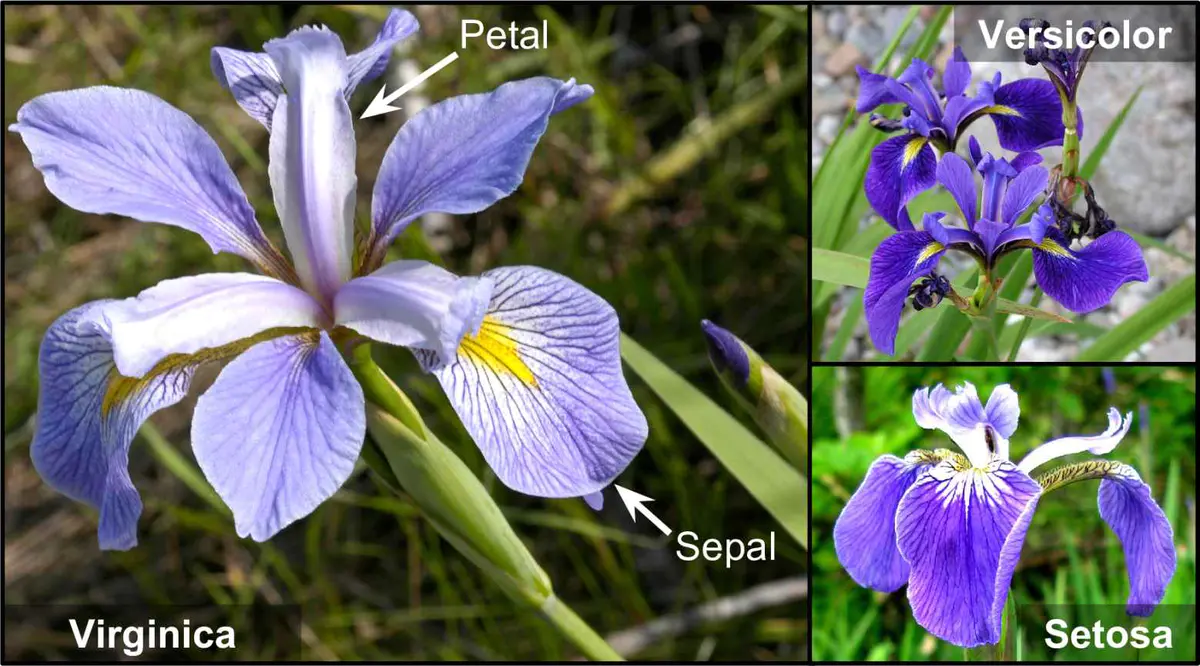
<br>
让我们尝试建立一个分类器，仅仅使用花瓣的宽度特征来识别 Virginica，首先让我们加载数据：

In [29]:
from sklearn import datasets
iris = datasets.load_iris()
list(iris.keys())
['data', 'target_names', 'feature_names', 'target', 'DESCR']
X = iris["data"][:, 3:] # 花瓣宽度
y = (iris["target"] == 2).astype(np.int)

接下来，我们训练一个逻辑回归模型：

In [30]:
from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression()
log_reg.fit(X, y)

LogisticRegression()

我们来看看模型估计的花瓣宽度从 0 到 3 厘米的概率估计

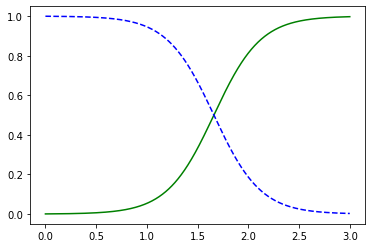

In [35]:
X_new = np.linspace(0, 3, 1000).reshape(-1, 1)
y_proba = log_reg.predict_proba(X_new)
plt.plot(X_new, y_proba[:, 1], "g-", label="Iris-Virginica")
plt.plot(X_new, y_proba[:, 0], "b--", label="Not Iris-Virginica")

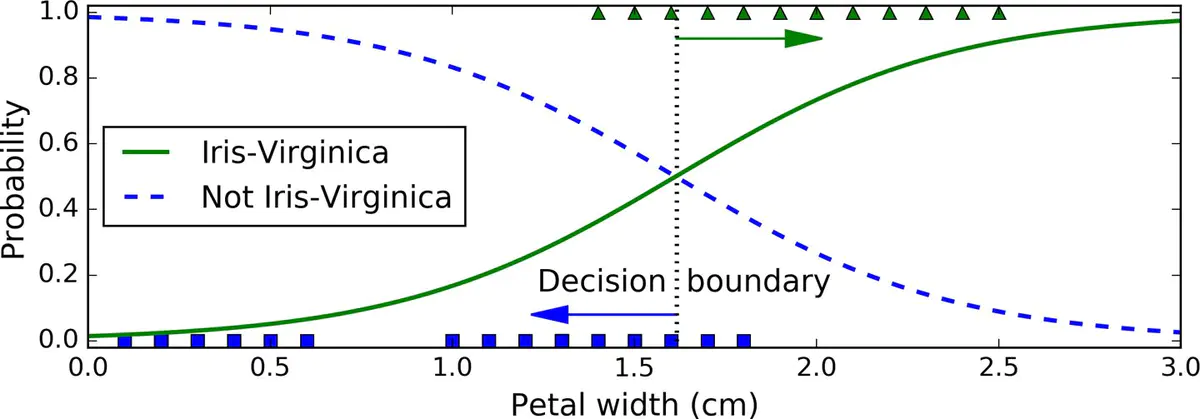

Virginica 花的花瓣宽度（用三角形表示）在 1.4 厘米到 2.5 厘米之间，而其他种类的花（由正方形表示）通常具有较小的花瓣宽度，范围从 0.1 厘米到 1.8 厘米。注意，它们之间会有一些重叠。在大约 2 厘米以上时，分类器非常肯定这朵花是Virginica花（分类器此时输出一个非常高的概率值），而在1厘米以下时，它非常肯定这朵花不是 Virginica 花（不是 Virginica 花有非常高的概率）。在这两个极端之间，分类器是不确定的。但是，如果你使用它进行预测（使用predict()方法而不是predict_proba()方法），它将返回一个最可能的结果。因此，在 1.6 厘米左右存在一个决策边界，这时两类情况出现的概率都等于 50%：如果花瓣宽度大于 1.6 厘米，则分类器将预测该花是 Virginica，否则预测它不是（即使它有可能错了）：


In [245]:
log_reg.predict([[1.7], [1.5]])

array([1, 0])

图 4-24 表示相同的数据集，但是这次使用了两个特征进行判断：花瓣的宽度和长度。 一旦训练完毕，Logistic 回归分类器就可以根据这两个特征来估计一朵花是 Virginica 的可能性。 虚线表示这时两类情况出现的概率都等于 50%：这是模型的决策边界。 请注意，它是一个线性边界。每条平行线都代表一个分类标准下的两两个不同类的概率，从 15%（左下角）到 90%（右上角）。越过右上角分界线的点都有超过 90% 的概率是 Virginica 花。<br>
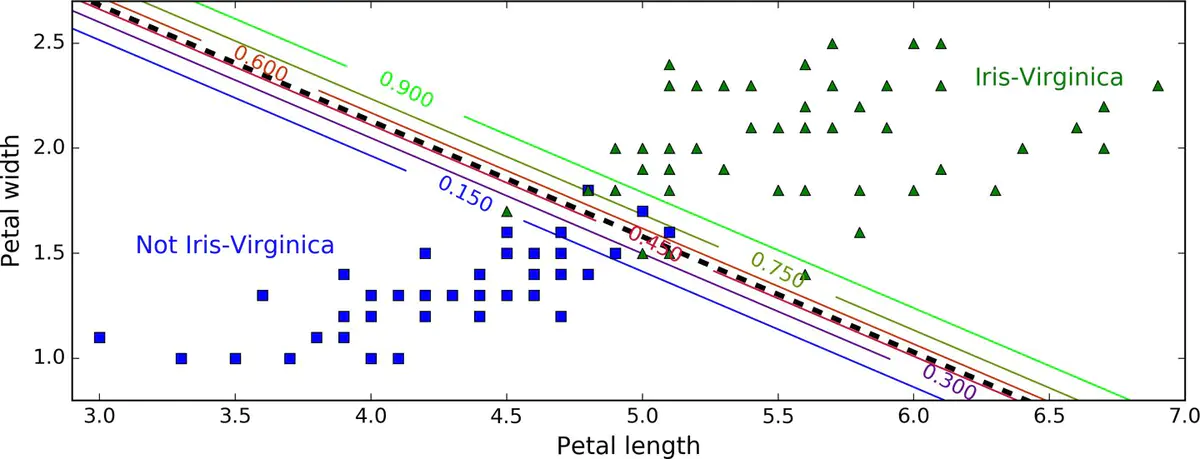

就像其他线性模型，逻辑回归模型也可以$\ell_1$或者$\ell_2$惩罚使用进行正则化。Scikit-Learn 默认添加了$\ell_2$惩罚。

注意<br>

在 Scikit-Learn 的LogisticRegression模型中控制正则化强度的超参数不是\alpha（与其他线性模型一样），而是它的逆：C。C的值越大，模型正则化强度越低。

## Softmax 回归
Logistic 回归模型可以直接推广到支持多类别分类，不必组合和训练多个二分类器（如第 3 章所述）， 其称为 Softmax 回归或多类别 Logistic 回归。

这个想法很简单：当给定一个实例时，Softmax 回归模型首先计算类的分数，然后将分数应用在Softmax函数（也称为归一化指数）上，估计出每类的概率。 计算的公式看起来很熟悉，因为它就像线性回归预测的公式一样（见公式 4-19）。

公式 4-19：类的 Softmax 得分


$$s_k(\mathbf{x})= \theta^T \cdot \mathbf{x}$$

注意，每个类都有自己独一无二的参数向量。 所有这些向量通常作为行放在参数矩阵中。

一旦你计算了样本的每一类的得分，你便可以通过Softmax函数（公式 4-20）估计出样本属于第类的概率：通过计算的次方，然后对它们进行归一化（除以所有分子的总和）。

公式 4-20：Softmax 函数

$$\hat{p_k}=\sigma{(\mathbf{s}(\mathbf{x}))}k= \frac{exp\left(s_k(\mathbf{x})\right)} {\sum_{j=1}^{K}exp\left(s_j(\mathbf{x})\right)}$$



K是类的个数<br>
$s(x)$实例的每个类的得分的向量<br>
$\sigma{(\mathbf{s}(\mathbf{x}))_k}$示给定每一类分数之后，实例属于第类的概率<br>
和 Logistic 回归分类器一样，Softmax 回归分类器将估计概率最高（它只是得分最高的类）的那类作为预测结果，如公式 4-21 所示。

公式 4-21：Softmax 回归模型分类器预测结果


$$\hat{y}=argmax\ \sigma{(\mathbf{s}(\mathbf{x}))_k}=argmax \ s_k(\mathbf{x})=argmax \ \left( \theta_k^T \cdot \mathbf{x}\right)$$

argmax运算返回一个函数取到最大值的变量值。 在这个等式，它返回使$\sigma{(\mathbf{s}(\mathbf{x}))_k}$时的的值
提示
Softmax 回归分类器一次只能预测一个类（即它是多类的，但不是多输出的），因此它只能用于判断互斥的类别，如不同类型的植物。 你不能用它来识别一张照片中的多个人。

现在我们知道这个模型如何估计概率并进行预测，接下来将介绍如何训练。我们的目标是建立一个模型在目标类别上有着较高的概率（因此其他类别的概率较低），最小化公式 4-22 可以达到这个目标，其表示了当前模型的损失函数，称为交叉熵，当模型对目标类得出了一个较低的概率，其会惩罚这个模型。 交叉熵通常用于衡量待测类别与目标类别的匹配程度（我们将在后面的章节中多次使用它）

公式 4-22：交叉熵

$$
J(\Theta)=-\frac{1}{m}\sum\limits_{i=1}^m\sum\limits_{k=1}^Ky_k^{(i)}log\left(\hat{p}_k^{(i)}\right)$$

如果对于第I个实例的目标类是k那么，$y_k^{(i)}=1，反之y_k^{(i)}=0。$。
可以看出，当只有两个类$（K=2）$此损失函数等同于 Logistic 回归的损失函数（对数损失；请参阅公式 4-17）。

交叉熵

交叉熵源于信息论。假设你想要高效地传输每天的天气信息。如果有八个选项（晴天，雨天等），则可以使用3位对每个选项进行编码，因为$2^3=8$是，如果你认为几乎每天都是晴天，更高效的编码“晴天”的方式是：只用一位（0）。剩下的七项使用四位（从 1 开始）。交叉熵度量每个选项实际发送的平均比特数。 如果你对天气的假设是完美的，交叉熵就等于天气本身的熵（即其内部的不确定性）。 但是，如果你的假设是错误的（例如，如果经常下雨）交叉熵将会更大，称为 Kullback-Leibler 散度（KL 散度）。

两个概率分布p之间的交叉熵定义为：$H(p,q)=-\sum_xp(x)\log q(x)$布至少是离散的）

这个损失函数关于的梯度向量为公式 4-23：

公式 4-23：类交叉熵的梯度向量
$$\nabla_{\theta_k}J(\Theta)=\frac{1}{m}\sum\limits_{i=1}^m\left(\hat{p}_k^{(i)}-y_k^{(i)}\right)\mathbf{x}^{(i)}$$


现在你可以计算每一类的梯度向量，然后使用梯度下降（或者其他的优化算法）找到使得损失函数达到最小值的参数矩阵$\Theta$。

让我们使用 Softmax 回归对三种鸢尾花进行分类。当你使用LogisticRregression对模型进行训练时，Scikit Learn 默认使用的是一对多模型，但是你可以设置multi_class参数为“multinomial”来把它改变为 Softmax 回归。你还必须指定一个支持 Softmax 回归的求解器，例如“lbfgs”求解器（有关更多详细信息，请参阅 Scikit-Learn 的文档）。其默认使用$\ell_12$正则化，你可以使用超参数$C$控制它。

In [36]:
X = iris["data"][:, (2, 3)] # petal length, petal width   
y = iris["target"]

softmax_reg = LogisticRegression(multi_class="multinomial",solver="lbfgs", C=10)
softmax_reg.fit(X, y)

LogisticRegression(C=10, multi_class='multinomial')

In [37]:
softmax_reg.predict([[5, 2]])

array([2])

In [38]:
softmax_reg.predict_proba([[5, 2]])

array([[6.38014896e-07, 5.74929995e-02, 9.42506362e-01]])

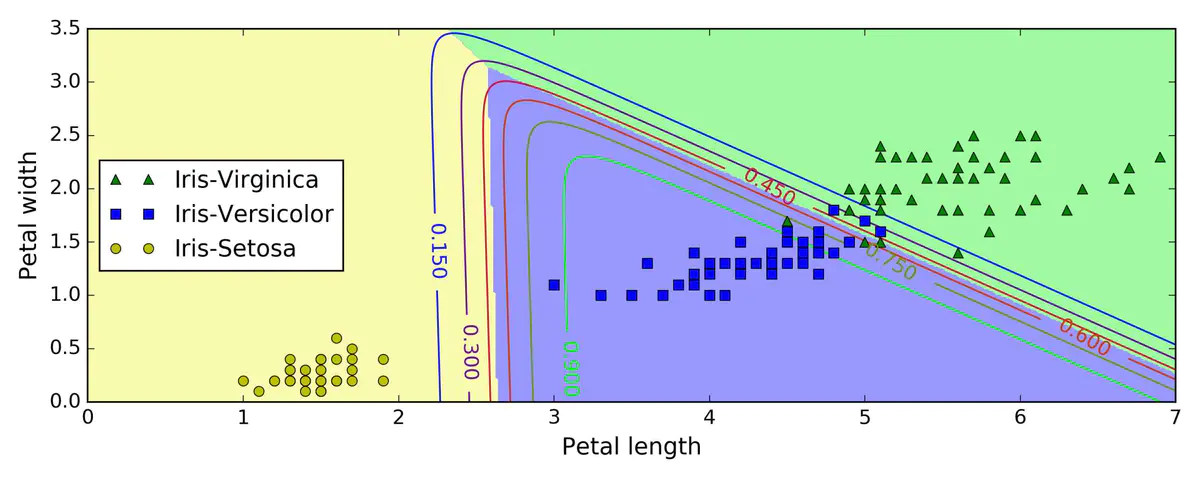<br>
图 4-25 用不同背景色表示了结果的决策边界。注意，任何两个类之间的决策边界是线性的。 该图的曲线表示 Versicolor 类的概率（例如，用 0.450 标记的曲线表示 45% 的概率边界）。注意模型也可以预测一个概率低于 50% 的类。 例如，在所有决策边界相遇的地方，所有类的估计概率相等，分别为 33%。